#### Arguments

In [1]:
args = {
    # General
    'seed': 42,
    'device': 'cpu',
    'root_dir': '/Users/svlg/MasterThesis/v02',

    # FlowMol
    'model': 'qm9_ctmc',
    'n_molecules': 1000,
    'n_timesteps': 50,

    # Reward model
    'reward_model': 'PAMNet_s',
    'n_layer': 6,
    'dim': 128,
    'target': 7,
    'cutoff_l': 5.0,
    'cutoff_g': 5.0,

    # Data / Dataset
    'dataset': 'QM9',
    'data_path': '/data',
    'batch_size': 1000,
}

In [2]:
import torch
import numpy as np
import random

def set_seed(seed):
    """Seed all random generators."""
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

set_seed(args['seed'])

#### Data

In [3]:
import os.path as osp
from torch_geometric.loader import DataLoader
from dataset.QM9 import QM9

In [4]:
data_root = osp.join(args['root_dir'] + args['data_path'])
train_dataset = QM9(data_root)
train_dataset.load(osp.join(data_root, 'qm9_train_data.pt'))
train_loader = DataLoader(train_dataset, batch_size=args['batch_size'], shuffle=True)
val_dataset = QM9(data_root)
val_dataset.load(osp.join(data_root, 'qm9_val_data.pt'))
val_loader = DataLoader(val_dataset, batch_size=args['batch_size'], shuffle=False)
test_dataset = QM9(data_root)
test_dataset.load(osp.join(data_root, 'qm9_test_data.pt'))
test_loader = DataLoader(test_dataset, batch_size=args['batch_size'], shuffle=False)

In [5]:
for batch_data in train_loader:
    print(batch_data)
    break

qm9_data = batch_data.to_data_list()
qm9_smiles = [data.smiles for data in qm9_data]

DataBatch(x=[17995, 5], edge_index=[2, 37264], edge_attr=[37264, 4], y=[1000, 19], pos=[17995, 3], z=[17995], smiles=[1000], idx=[1000], batch=[17995], ptr=[1001])


In [6]:
from rdkit import Chem
from rdkit.Geometry.rdGeometry import Point3D
bond_type_map = [Chem.rdchem.BondType.SINGLE, 
                 Chem.rdchem.BondType.DOUBLE, 
                 Chem.rdchem.BondType.TRIPLE,
                 Chem.rdchem.BondType.AROMATIC, 
                 None] # last bond type is for masked bonds

In [7]:
def pyg_to_rdmol(positions, atom_types, bond_src_idxs, bond_dst_idxs, bond_types):
    """Builds a rdkit molecule from the given atom and bond information."""
    # create a rdkit molecule and add atoms to it
    mol = Chem.RWMol()
    for atom_type in atom_types:
        a = Chem.Atom(int(atom_type))
        mol.AddAtom(a)

    # add bonds to rdkit molecule
    visited = set()
    for bond_type, src_idx, dst_idx in zip(bond_types, bond_src_idxs, bond_dst_idxs):
        src_idx = int(src_idx)
        dst_idx = int(dst_idx)
        if (src_idx, dst_idx) in visited or (dst_idx, src_idx) in visited:
            continue
        mol.AddBond(src_idx, dst_idx, bond_type_map[bond_type])
        visited.add((src_idx, dst_idx))

    try:
        mol = mol.GetMol()
    except Chem.KekulizeException:
        return None

    # Set coordinates
    conf = Chem.Conformer(mol.GetNumAtoms())
    for i in range(mol.GetNumAtoms()):
        x, y, z = positions[i]
        x, y, z = float(x), float(y), float(z)
        conf.SetAtomPosition(i, Point3D(x,y,z))
    mol.AddConformer(conf)

    return mol

In [8]:
qm9_rdkit_mols = []
for data in qm9_data:
    mol = pyg_to_rdmol(data.pos, data.z.tolist(), data.edge_index[0].tolist(), data.edge_index[1].tolist(), torch.argmax(data.edge_attr, dim=1))
    qm9_rdkit_mols.append(mol)

In [9]:
def show_mol(index):
    import py3Dmol

    pdb_block = Chem.MolToMolBlock(qm9_rdkit_mols[index])

    # Visualize using py3Dmol
    viewer = py3Dmol.view(width=250, height=250)
    viewer.addModel(pdb_block, "mol")
    viewer.setStyle({"stick": {}, "sphere": {"scale": 0.3}})
    viewer.zoomTo()
    viewer.show()

show_mol(50)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

#### Sampling

In [10]:
import flowmol

In [11]:
model = flowmol.load_pretrained(args['model'])
model = model.to(args['device'])
model.eval()

FlowMol(
  (interpolant_scheduler): InterpolantScheduler()
  (vector_field): CTMCVectorField(
    (interpolant_scheduler): InterpolantScheduler()
    (scalar_embedding): Sequential(
      (0): Linear(in_features=14, out_features=256, bias=True)
      (1): SiLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): SiLU()
      (4): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    )
    (edge_embedding): Sequential(
      (0): Linear(in_features=6, out_features=128, bias=True)
      (1): SiLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): SiLU()
      (4): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (conv_layers): ModuleList(
      (0-7): 8 x GVPConv(
        (edge_message): Sequential(
          (0): GVP(
            (vectors_activation): Sigmoid()
            (to_feats_out): Sequential(
              (0): Linear(in_features=437, out_features=256, bias=True)
              (1): SiLU()
            )
        

In [ ]:
print(f"Sampling {args['n_molecules']} molecules...")
generated_molecules = model.sample_random_sizes(n_molecules=args['n_molecules'], n_timesteps=args['n_timesteps'], device=args['device'])

In [ ]:
gen_rdkit_molecules = []
gen_smiles = []
for mol in generated_molecules:
    gen_rdkit_molecules.append(mol.rdkit_mol)
    gen_smiles.append(mol.smiles)

#### XTB Simulation

In [12]:
from true_reward import xtb_simulation

In [ ]:
#  Calculate the true reward
for mol in qm9_data[:10]:
    quantity_value = xtb_simulation.compute_true_reward(mol, "pyg", "homolumo")
    homolumo_gap, lumo, homo = quantity_value
    print(f"HOMO-LUMO gap: {homolumo_gap:.4f} eV")
    print(f"LUMO: {lumo} eV\nHOMO: {homo} eV")

In [ ]:
#  Calculate the true reward
for mol in generated_molecules:
    quantity_value = xtb_simulation.compute_true_reward(mol.g, "dgl", "homolumo")
    homolumo_gap, lumo, homo = quantity_value
    print(f"HOMO-LUMO gap: {homolumo_gap:.6f} eV")
    print(f"LUMO: {lumo} eV\nHOMO: {homo} eV")

#### Compare 1000 Molecules wrt there Homolumo Energy

In [ ]:
## Run-Time ca. 1m40 / 1000 mol

qm9_gap_pyg = []
qm9_homo_lumo_pyg = []
for mol in qm9_data:
    quantity_value = xtb_simulation.compute_true_reward(mol, "pyg", "homolumo")
    gap, lumo, homo = quantity_value
    qm9_gap_pyg.append(gap)
    qm9_homo_lumo_pyg.append((lumo, homo))

qm9_gap_pyg = np.array(qm9_gap_pyg)
qm9_homo_lumo_pyg = np.array(qm9_homo_lumo_pyg)

In [ ]:
## Run-Time ca. 1m44 / 1000 mol 

qm9_gap_rd = []
qm9_homo_lumo_rd = []
for mol in qm9_rdkit_mols:
    quantity_value = xtb_simulation.compute_true_reward(mol, "rdkit", "homolumo")
    gap, lumo, homo = quantity_value
    qm9_gap_rd.append(gap)
    qm9_homo_lumo_rd.append((lumo, homo))

qm9_gap_rd = np.array(qm9_gap_rd)
qm9_homo_lumo_rd = np.array(qm9_homo_lumo_rd)

In [ ]:
from datetime import datetime
current_time = datetime.now().strftime('%Y%m%d%H')
np.save(f"output/qm9_gap_pyg_{current_time}.npy", qm9_gap_pyg)
np.save(f"output/qm9_homo_lumo_pyg_{current_time}.npy", qm9_homo_lumo_pyg)
np.save(f"output/qm9_gap_rd_{current_time}.npy", qm9_gap_rd)
np.save(f"output/qm9_homo_lumo_rd_{current_time}.npy", qm9_homo_lumo_rd)

In [21]:
args['n_molecules'] = 25

In [33]:
gen_gap_dgl = []
gen_homo_lumo_dgl = []
gen_gap_rd = []
gen_homo_lumo_rd = []
for i in range(40):
    print(f"Round {i+1} - Sampling {args['n_molecules']} molecules...")
    tmp_molecules = model.sample_random_sizes(n_molecules=args['n_molecules'], n_timesteps=args['n_timesteps'], device=args['device'])
    for mol in tmp_molecules:
        quantity_value = xtb_simulation.compute_true_reward(mol.g, "dgl", "homolumo")
        gap, lumo, homo = quantity_value
        gen_gap_dgl.append(gap)
        gen_homo_lumo_dgl.append((lumo, homo))
        quantity_value = xtb_simulation.compute_true_reward(mol.rdkit_mol, "rdkit", "homolumo")
        gap, lumo, homo = quantity_value
        gen_gap_rd.append(gap)
        gen_homo_lumo_rd.append((lumo, homo))

Round 1 - Sampling 25 molecules...
Round 2 - Sampling 25 molecules...
Round 3 - Sampling 25 molecules...
Round 4 - Sampling 25 molecules...
Round 5 - Sampling 25 molecules...
Round 6 - Sampling 25 molecules...
Round 7 - Sampling 25 molecules...
Round 8 - Sampling 25 molecules...
Round 9 - Sampling 25 molecules...
Round 10 - Sampling 25 molecules...
Round 11 - Sampling 25 molecules...
Round 12 - Sampling 25 molecules...
Round 13 - Sampling 25 molecules...
Round 14 - Sampling 25 molecules...
Round 15 - Sampling 25 molecules...
Round 16 - Sampling 25 molecules...
Round 17 - Sampling 25 molecules...
Round 18 - Sampling 25 molecules...
Round 19 - Sampling 25 molecules...
Round 20 - Sampling 25 molecules...
Round 21 - Sampling 25 molecules...


rm: charges: No such file or directory
rm: wbo: No such file or directory
rm: xtbrestart: No such file or directory
rm: xtbtopo.mol: No such file or directory


Round 22 - Sampling 25 molecules...
Round 23 - Sampling 25 molecules...
Round 24 - Sampling 25 molecules...
Round 25 - Sampling 25 molecules...
Round 26 - Sampling 25 molecules...
Round 27 - Sampling 25 molecules...
Round 28 - Sampling 25 molecules...
Round 29 - Sampling 25 molecules...
Round 30 - Sampling 25 molecules...
Round 31 - Sampling 25 molecules...
Round 32 - Sampling 25 molecules...
Round 33 - Sampling 25 molecules...


rm: charges: No such file or directory
rm: wbo: No such file or directory
rm: xtbrestart: No such file or directory
rm: xtbtopo.mol: No such file or directory


Round 34 - Sampling 25 molecules...
Round 35 - Sampling 25 molecules...
Round 36 - Sampling 25 molecules...


rm: charges: No such file or directory
rm: wbo: No such file or directory
rm: xtbrestart: No such file or directory
rm: xtbtopo.mol: No such file or directory


Round 37 - Sampling 25 molecules...
Round 38 - Sampling 25 molecules...
Round 39 - Sampling 25 molecules...
Round 40 - Sampling 25 molecules...


In [34]:
np.save(f"output/gen_gap_dgl_{current_time}.npy", gen_gap_dgl)
np.save(f"output/gen_homo_lumo_pgy_{current_time}.npy", gen_homo_lumo_dgl)
np.save(f"output/gen_gap_rd_{current_time}.npy", gen_gap_rd)
np.save(f"output/gen_homo_lumo_rd_{current_time}.npy", gen_homo_lumo_rd)

In [ ]:
gen_gap_dgl = np.load(f"output/gen_gap_dgl_{current_time}.npy") 
gen_gap_rd = np.load(f"output/gen_gap_rd_{current_time}.npy") 
qm9_gap_rdqm9_gap_pyg = np.load(f"output/qm9_gap_pgy_{current_time}.npy")
qm9_gap_rd = np.load(f"output/qm9_gap_rd_{current_time}.npy")

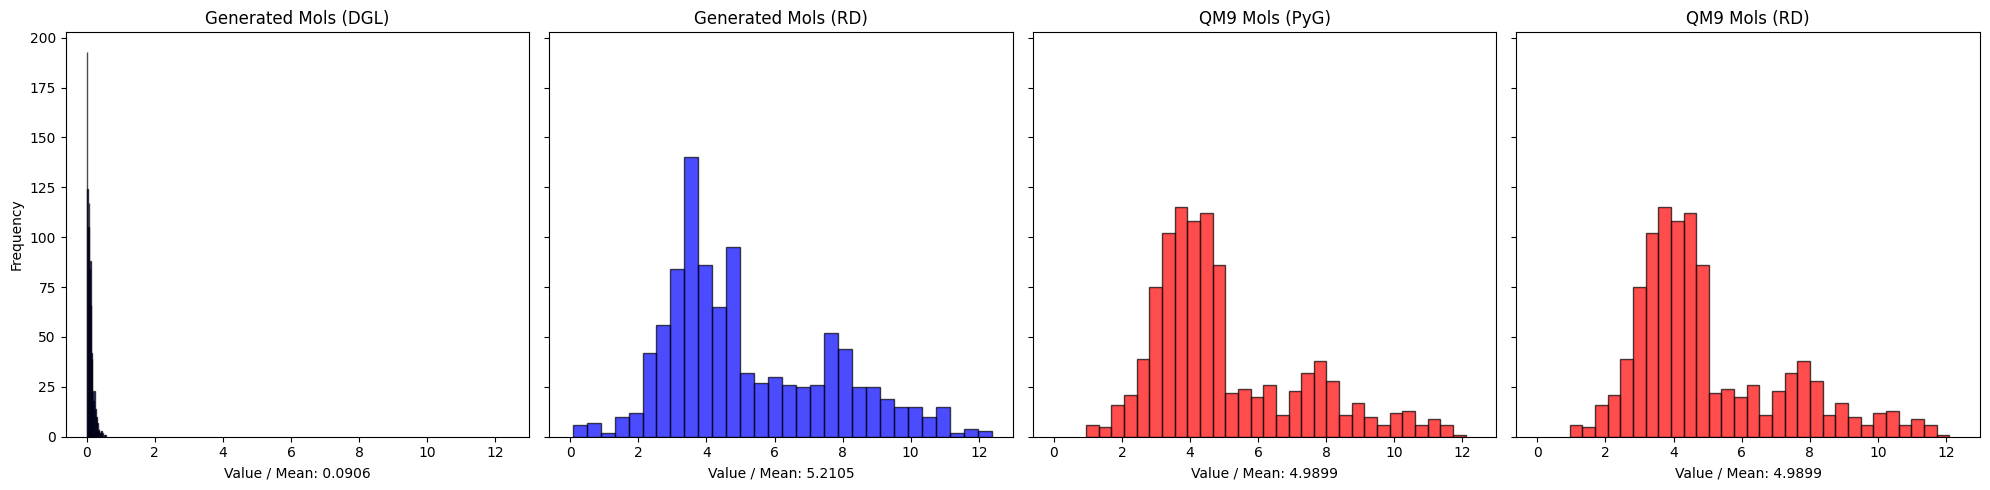

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# Define the number of bins (adjustable)
num_bins = 30

# Create the figure and axes for 3 subplots
fig, ax = plt.subplots(1, 4, figsize=(20, 5), sharey=True, sharex=True)  # 1 row, 3 columns

ax[0].hist(gen_gap_dgl, bins=num_bins, alpha=0.7, color='blue', edgecolor='black')
ax[0].set_title('Generated Mols (DGL)')
tmp = np.mean(gen_gap_dgl)
ax[0].set_xlabel(f'Value / Mean: {tmp:.4f}')
ax[0].set_ylabel('Frequency')

ax[1].hist(gen_gap_rd, bins=num_bins, alpha=0.7, color='blue', edgecolor='black')
ax[1].set_title('Generated Mols (RD)')
tmp = np.mean(gen_gap_rd)
ax[1].set_xlabel(f'Value / Mean: {tmp:.4f}')

ax[2].hist(qm9_gap_pyg, bins=num_bins, alpha=0.7, color='red', edgecolor='black')
ax[2].set_title('QM9 Mols (PyG)')
tmp = np.mean(qm9_gap_pyg)
ax[2].set_xlabel(f'Value / Mean: {tmp:.4f}')

ax[3].hist(qm9_gap_rd, bins=num_bins, alpha=0.7, color='red', edgecolor='black')
ax[3].set_title('QM9 Mols (RD)')
tmp = np.mean(qm9_gap_rd)
ax[3].set_xlabel(f'Value / Mean: {tmp:.4f}')

# Plot both histograms with overlay
# ax[2].hist(gen_gap, bins=num_bins, alpha=0.7, color='blue', label='Gen', edgecolor='black')
# ax[2].hist(qm9_gap, bins=num_bins, alpha=0.7, color='red', label='qm9', edgecolor='black')
# ax[2].set_title('Overlaid Histograms')
# ax[2].set_xlabel('Value')
# ax[2].legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

#### Differentiable Reward

In [ ]:
from PAMNet.models import PAMNet_s, Config

In [ ]:
config = Config(dataset=args['dataset'], dim=args['dim'], n_layer=args['n_layer'], cutoff_l=args['cutoff_l'], cutoff_g=args['cutoff_g'])
reward_model = PAMNet_s(config).to(args['device'])
reward_model.eval()

In [ ]:
targets = []
for data in generated_molecules:
    data = data.pyg_mol
    data.pos.requires_grad_()
    tmp = reward_model(data)
    targets.append(tmp)
    tmp.backward()
    pos_grad = data.pos.grad
print(len(targets))
print(data.pos.shape)
print(pos_grad.shape)

#### Visualize the Molecules

In [ ]:
import py3Dmol

In [ ]:
# Convert RDKit Mol to PDB block
pdb_blocks = []
for mol in gen_rdkit_molecules:
    pdb_blocks.append(Chem.MolToMolBlock(mol))

# Visualize using py3Dmol
viewer = py3Dmol.view(width=600, height=600, viewergrid=(3, 3))
viewer.addModel(pdb_blocks[0], "mol", viewer=(0, 0))
viewer.addModel(pdb_blocks[1], "mol", viewer=(0, 1))
viewer.addModel(pdb_blocks[2], "mol", viewer=(0, 2))
viewer.addModel(pdb_blocks[3], "mol", viewer=(1, 0))
viewer.addModel(pdb_blocks[4], "mol", viewer=(1, 1))
viewer.addModel(pdb_blocks[5], "mol", viewer=(1, 2))
viewer.addModel(pdb_blocks[6], "mol", viewer=(2, 0))
viewer.addModel(pdb_blocks[7], "mol", viewer=(2, 1))
viewer.addModel(pdb_blocks[8], "mol", viewer=(2, 2))
viewer.setStyle({"stick": {}, "sphere": {"scale": 0.3}})
viewer.zoomTo()
viewer.show()